# Modelos de Regresión

## Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, make_scorer, r2_score, mean_squared_error)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


## Carga de datos

In [2]:
df = pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv", parse_dates=["order_delivered_customer_date", "order_estimated_delivery_date"])
dist_df = pd.read_csv("../data_clean/ordenes_con_distancia.csv")

## Carga de características y agrupación

In [3]:
df.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"], inplace=True)
df["delivery_diff_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days

def clasificar_retraso(x):
    if x <= 0:
        return "puntual"
    elif x <= 5:
        return "ligero"
    else:
        return "grave"

df["retraso_clase"] = df["delivery_diff_days"].apply(clasificar_retraso)

Se calcula el número de días de retraso de las entregas y se clasifica en tres categorías: puntual, ligero o grave.

## Unión con dataset de distancia

In [4]:
df = df.merge(dist_df, on="order_id", how="inner")

Se combinan las distancias a los pedidos utilizando `order_id` como clave.


## Selección y transformación de variables

In [5]:
features = ["price", "freight_value", "product_weight_g", "product_length_cm",
            "product_width_cm", "product_height_cm", "distancia_km"]

X = df[features]
y_clf = df["retraso_clase"]
y_reg = df["delivery_diff_days"]

le = LabelEncoder()
y_clf_encoded = le.fit_transform(y_clf)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## División de datos y balanceo

In [6]:
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X_scaled, y_clf_encoded, test_size=0.2, stratify=y_clf_encoded, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_clf)

## Funciones de evaluación

In [7]:
def evaluarModeloClasificacion(modelo, X_test, y_test, etiquetas):
    y_pred = modelo.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=etiquetas))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=etiquetas, cmap="Blues", normalize="true")
    plt.title(f"Matriz de confusión normalizada - {type(modelo).__name__}")
    plt.tight_layout()
    plt.show()

def evaluarModeloRegresion(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R^2: {r2:.4f}, RMSE: {rmse:.4f}")

Funciones auxiliares para mostrar reportes de clasificación y regresión.

## Entrenamiento de clasificadores


Entrenando: RandomForest
              precision    recall  f1-score   support

       grave       0.29      0.23      0.26       863
      ligero       0.27      0.23      0.25       644
     puntual       0.95      0.96      0.96     22176

    accuracy                           0.92     23683
   macro avg       0.51      0.47      0.49     23683
weighted avg       0.91      0.92      0.91     23683



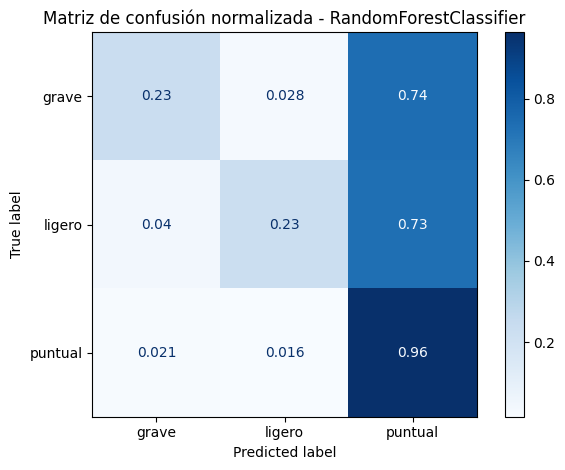


Entrenando: XGBoost
              precision    recall  f1-score   support

       grave       0.11      0.20      0.15       863
      ligero       0.09      0.12      0.10       644
     puntual       0.95      0.91      0.93     22176

    accuracy                           0.86     23683
   macro avg       0.38      0.41      0.39     23683
weighted avg       0.89      0.86      0.87     23683



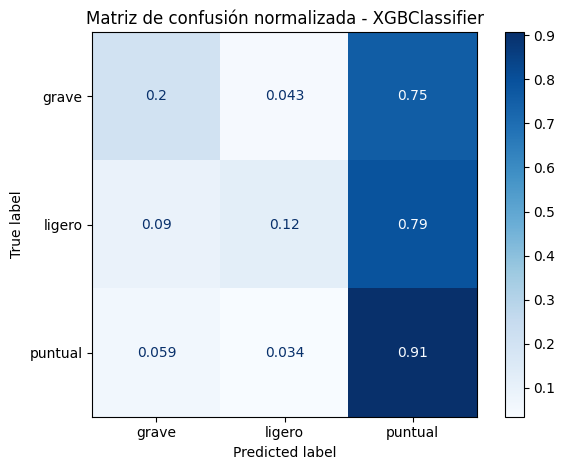


Entrenando: LogisticRegression
              precision    recall  f1-score   support

       grave       0.06      0.39      0.10       863
      ligero       0.02      0.14      0.04       644
     puntual       0.95      0.59      0.73     22176

    accuracy                           0.58     23683
   macro avg       0.34      0.37      0.29     23683
weighted avg       0.89      0.58      0.69     23683



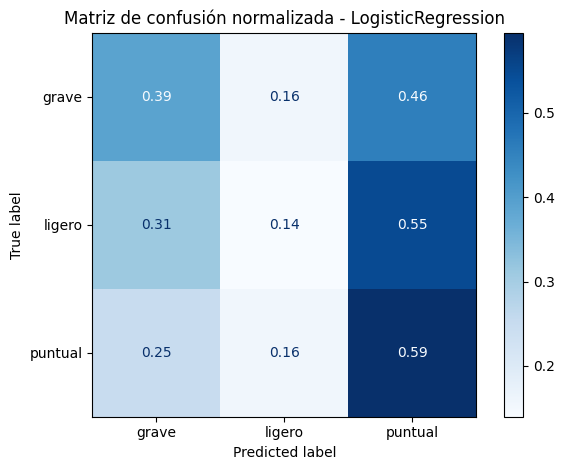


Entrenando: KNN
              precision    recall  f1-score   support

       grave       0.10      0.40      0.16       863
      ligero       0.07      0.31      0.11       644
     puntual       0.96      0.75      0.84     22176

    accuracy                           0.72     23683
   macro avg       0.38      0.49      0.37     23683
weighted avg       0.90      0.72      0.80     23683



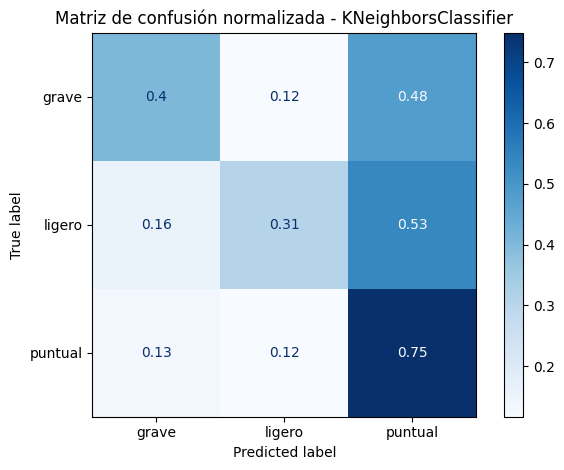


Entrenando: NaiveBayes
              precision    recall  f1-score   support

       grave       0.06      0.31      0.10       863
      ligero       0.03      0.08      0.05       644
     puntual       0.94      0.75      0.83     22176

    accuracy                           0.71     23683
   macro avg       0.35      0.38      0.33     23683
weighted avg       0.89      0.71      0.79     23683



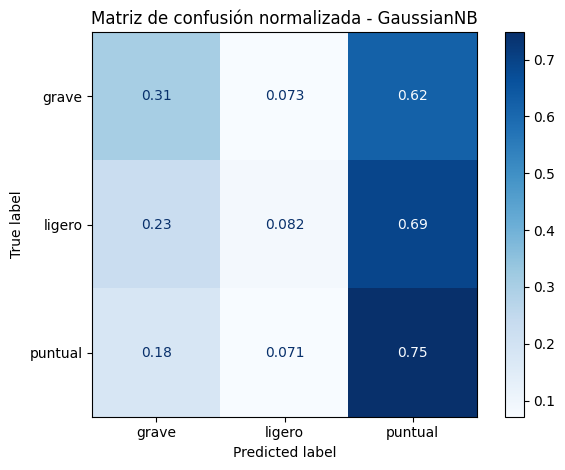


Entrenando: DecisionTree
              precision    recall  f1-score   support

       grave       0.13      0.29      0.18       863
      ligero       0.11      0.27      0.16       644
     puntual       0.95      0.87      0.91     22176

    accuracy                           0.83     23683
   macro avg       0.40      0.48      0.42     23683
weighted avg       0.90      0.83      0.86     23683



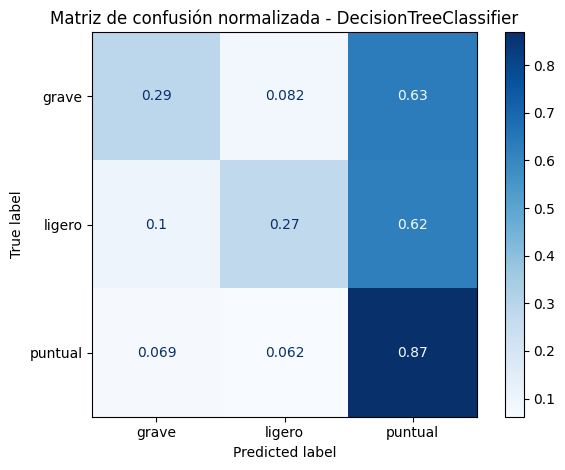

In [8]:
modelos_clasificacion = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

for nombre, modelo in modelos_clasificacion.items():
    print(f"\nEntrenando: {nombre}")
    modelo.fit(X_resampled, y_resampled)
    evaluarModeloClasificacion(modelo, X_test, y_test_clf, le.classes_)

## Entrenamiento de regresores

In [9]:
modelos_regresion = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "SVR": SVR(kernel="rbf")
}

for nombre, modelo in modelos_regresion.items():
    print(f"\nEntrenando regresión: {nombre}")
    modelo.fit(X_train, y_train_reg)
    evaluarModeloRegresion(modelo, X_test, y_test_reg)


Entrenando regresión: RandomForestRegressor
R^2: -0.1699, RMSE: 10.8648

Entrenando regresión: SVR
R^2: -0.0047, RMSE: 10.0684


## Optimización con GridSearch

In [10]:
def optimizarModelo(modelo, parametros, X, y):
    grid = GridSearchCV(modelo, parametros, scoring="f1_macro", cv=3, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    print("Mejores parámetros:", grid.best_params_)
    print("Mejor f1_macro:", grid.best_score_)
    return grid.best_estimator_

In [ ]:
modelo = RandomForestClassifier(random_state=42)
parametros = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

mejor_modelo = optimizarModelo(modelo, parametros, X_resampled, y_resampled)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Función para encontrar los mejores hiperparámetros con búsqueda en rejilla.

## Análisis general